In [4]:
import os
import pandas as pd
import numpy as np
import time
import q4functions as q4funcs
import progressbar

def predict(train, test, n_ap):
    pass


def get_training_data(path, calculate_means_and_variances=True):
    ''' Loads in training data from path argument, and returns in matrix for with mac addresses as columns.
        If calculate_means_and_variances=True the entries are the means and standard deviations of the readings,
        else just a list of all samples is returned
    '''
    print(f'Loading training data from {path}')
    time.sleep(0.2)
    locations_df = pd.read_csv(os.path.join(path, 'location.txt'), header=None)
    locations_df.columns = ['x', 'y']
    features_path = os.path.join(path, 'wifi_signal')
    feature_csvs = os.listdir(features_path)
    train_df = pd.DataFrame()
    for feature_csv in feature_csvs:
        location = np.array(locations_df.iloc[int(feature_csv[6:].split('.')[0]) - 1])
        #         corresponding_location = locations_df[]
        feature_df = pd.read_csv(os.path.join(features_path, feature_csv), header=None)
        feature_df.columns = ['timestamp', 'router_name', 'mac_address', 'channel', 'RSSI']
        unique_mac_addresses = list(set(feature_df['mac_address']))
        location_dict = {'x': location[0], 'y': location[1]}

        for unique_mac_address in unique_mac_addresses:
            relevant_entries = feature_df.iloc[np.where(feature_df['mac_address'] == unique_mac_address)]
            rssi_values = relevant_entries['RSSI'] #+ 0.5 * np.random.random(size=len(relevant_entries))
            if calculate_means_and_variances:
                #             add artificial noise to avoid 0 standard deviation
                mean = rssi_values.mean()
                std_dv = rssi_values.std()
                means_and_stdevs = [mean, std_dv]
                location_dict[unique_mac_address] = means_and_stdevs
            else:
                location_dict[unique_mac_address] = rssi_values
        train_df = train_df.append(location_dict, ignore_index=True)
    train_df = train_df.reindex(columns=['x', 'y'] + [col for col in train_df.columns if col not in ['x', 'y']])
    return train_df


def get_test_data(path):
    locations_df = pd.read_csv(os.path.join(path, 'location.txt'), header=None)
    features_path = os.path.join(path, 'wifi_signal')
    feature_csvs = os.listdir(features_path)
    test_df = pd.DataFrame()
    for feature_csv in feature_csvs:

        feature_df = pd.read_csv(os.path.join(features_path, feature_csv))
        feature_df.columns = ['timestamp', 'router_name', 'mac_address', 'channel', 'RSSI']
        unique_mac_addresses = list(set(feature_df['mac_address']))
        location_dict = {'x': 0, 'y': 0}

        for unique_mac_address in unique_mac_addresses:
            relevant_entries = feature_df.iloc[np.where(feature_df['mac_address'] == unique_mac_address)]
            rssi_values = relevant_entries['RSSI']
            location_dict[unique_mac_address] = rssi_values
        test_df = test_df.append(location_dict, ignore_index=True)
    test_df = test_df.reindex(columns=['x', 'y'] + [col for col in test_df.columns if col not in ['x', 'y']])
    return test_df


def make_predictions(train_data, test_data):
    locations = []
    for i in range(len(test_data)):
        test_features = pd.DataFrame(test_data.iloc[i]).transpose()
        #print(test_features)
        
        
        test_mac_addresses = set(test_features.columns[2:])
        train_mac_addresses = set(train_data.columns[2:])
        mutual_mac_addresses = list(test_mac_addresses.intersection(train_mac_addresses))
        cropped_test_df = test_features[['x', 'y'] + mutual_mac_addresses]

        #cropped_test_df = pd.DataFrame(cropped_test_df.apply(lambda x: np.mean(x[0]))).transpose()
        for i in range(len(cropped_test_df.columns[2:])):
            cropped_test_df.iloc[0,2+i] = np.nanmean(cropped_test_df.iloc[0,2+i])
        cropped_train_df = train_data[['x', 'y'] + mutual_mac_addresses]

        _, location = q4funcs.predict(cropped_train_df.values, cropped_test_df.values, len(cropped_test_df.columns[2:]))
        #print(location)
        locations.append(location)

    print(locations)
    return locations


def preprocess_training_data(*args):
    pass


training_path = "./real_data/training/"
test_path = "./real_data/test/"

# get_training_data(training_path,calculate_means_and_variances=True).head()
test_data = get_test_data(test_path)
train_data = get_training_data(training_path)

locations = make_predictions(train_data, test_data)


# b = b.values

Loading training data from ./real_data/training/


/Users/shaan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice
/Users/shaan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/shaan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


done now
done now
done now
[array([[6.59973983, 5.0841557 ]]), array([[5.21988699, 3.5839244 ]]), array([[5.2613543 , 3.66357822]])]


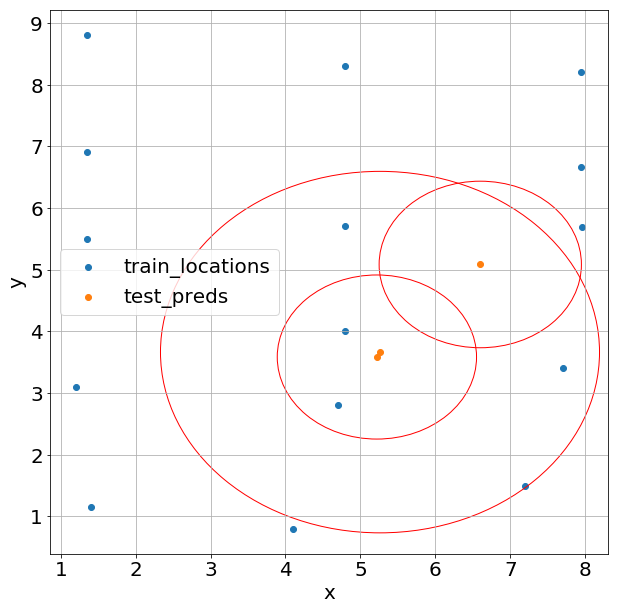

In [20]:
import matplotlib.pyplot as plt

circle1 = plt.Circle((locations[0,0,0], locations[0,0,1]), np.array([1.35]), color='r',fill=False)
circle2 = plt.Circle((locations[1,0,0], locations[1,0,1]), np.array([1.33]), color='r',fill=False)
circle3 = plt.Circle((locations[2,0,0], locations[2,0,1]), np.array([2.93]), color='r',fill=False)

fig, ax = plt.subplots(figsize=(10,10)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()
ax.scatter(train_data.loc[:,['x']].values,train_data.loc[:,['y']].values,label='train_locations')
ax.scatter(locations[:,0,0],locations[:,0,1],label="test_preds")
ax.legend(fontsize=fs)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
fs = 20
ax.grid(True)
plt.xlabel('x',fontsize=fs)
plt.ylabel('y',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.savefig('q4.svg',bbox_inches='tight')


In [6]:
locations

[array([[6.59973983, 5.0841557 ]]),
 array([[5.21988699, 3.5839244 ]]),
 array([[5.2613543 , 3.66357822]])]

In [7]:
locations = np.array(locations)

In [8]:
locations[:,0,:]

array([[6.59973983, 5.0841557 ],
       [5.21988699, 3.5839244 ],
       [5.2613543 , 3.66357822]])

In [9]:
np.savetxt("test_locations.txt", locations[:,0,:], delimiter=",")

In [10]:
!python submit.py

Point 1 tested, prediction error is 1.35 m
Point 2 tested, prediction error is 1.33 m
Point 3 tested, prediction error is 2.93 m
Average Prediction Error: 1.87 m
